<h1><center>

</center></h1>
<font size="6"><center>
EIE 401
PROCESAMIENTO DIGITAL MULTIMEDIA 
</center></font>


<center><h2>Proyecto 1</h2></center>
<center><h3>Procesamiento digital de señales</h3></center>
<center><h3>Profesor: Jorge Cardenas</h3></center>

<center><h3>Por: Javier Brito</h3></center>
<center><h5>Pontificia Universidad Catolica de Valparaiso</h5></center>
 

In [1]:
from IPython.display import IFrame, display
filepath = "Proyecto_1_EIE401.pdf"
IFrame(filepath, width=700, height=400)

Debes usar el sitio https://gwosc.org/eventapi/html/GWTC/, donde encuentras todo el catálogo de observaciones con los datos en diferentes formatos. Debes seleccionar una detección para tu estudio y descargar los datos correspondientes (H5 o TXT), lo que posteriormente deberás tratar de manera digital como audio (serie de tiempo).
tip: Te recomiendo tomar la serie de tiempo corta (32 segundos) para facilitar el análisis, y asegurarte de tomar la tasa de muestreo más alta.
tip: Asegúrate de tomar un caso cuyo espectrograma de muestra, indique una señal clara y fuerte para facilitar tu trabajo, de otra forma es posible que no logres aislarla lo suficiente.


## 1. Carga de Datos


In [2]:
import matplotlib.pyplot as plt

with open('L-L1_GWOSC_16KHZ_R1-1267963136-32.txt', 'r') as file:
    ## Ignora las primeras tres líneas de comentarios
    for _ in range(3):
        next(file)
    # Lee los datos como números de punto flotante
    data_L1 = [float(line.strip()) for line in file]

with open('H-H1_GWOSC_16KHZ_R1-1267963136-32.txt', 'r') as file:
    ## Ignora las primeras tres líneas de comentarios
    for _ in range(3):
        next(file)
    # Lee los datos como números de punto flotante
    data_H1 = [float(line.strip()) for line in file]

sampling_rate = 16384
time = [i / sampling_rate for i in range(len(data_H1))]

### Se cargan los datos de ambos sensores, los cuales son "L1" y "H1" respectivamente.

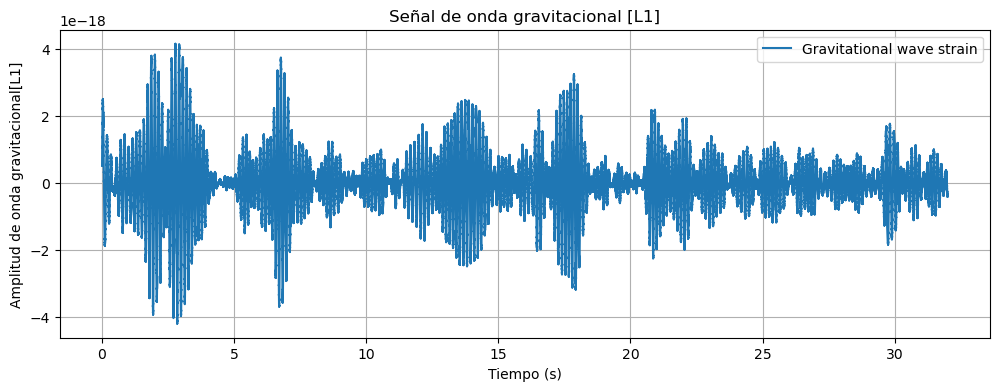

In [3]:
plt.figure(figsize=(12, 4))
plt.plot(time, data_L1, label='Gravitational wave strain')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud de onda gravitacional[L1]')
plt.title('Señal de onda gravitacional [L1]')
plt.grid(True)
plt.legend()
plt.show()

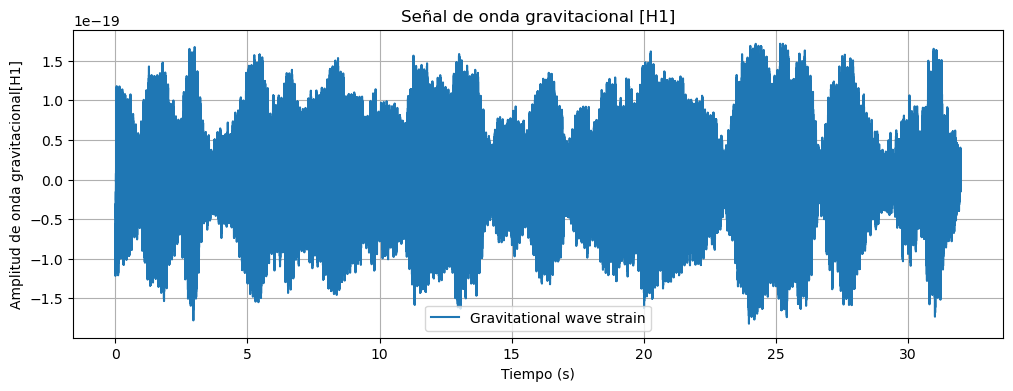

In [4]:
plt.figure(figsize=(12, 4))
plt.plot(time, data_H1, label='Gravitational wave strain')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud de onda gravitacional[H1]')
plt.title('Señal de onda gravitacional [H1]')
plt.grid(True)
plt.legend()
plt.show()

## 2. Convertir en audio
Es una forma de validar que tenemos un alto componente de ruido en la señal y que el interés es eliminarlo para encontrar una señal candidata.

Te recomiendo hacer una señal de audio de cada uno de las etapas para así validar como va el proceso. Al final deberás obtener un señal con CHIRP o BUMP. Son sonidos que comprueban que tienes una cantidad de potencia que sobre destaca sobre el ruido.

### 2. Segmentacion y reproduccion de audio

* En general se utilizara la data de "H1", cabe aclarar esto antes de continuar con el procesado de la señal.

In [5]:
import torch
import numpy as np
from scipy.io import wavfile

def save_audio_segment(segment_data, segment_index, sample_rate):
    # Normaliza los datos entre -1 y 1
    segment_data_normalized = segment_data / max(np.abs(segment_data))
    # Convertir el array de NumPy a un tensor de PyTorch
    audio_tensor = torch.tensor(segment_data_normalized)
    # Genera el archivo de audio
    wavfile.write(f'segment_{segment_index}.wav', sample_rate, audio_tensor.numpy())

def play_audio_segment(segment_data, sample_rate):
    # Normaliza los datos entre -1 y 1
    segment_data_normalized = segment_data / max(np.abs(segment_data))
    # Convertir el array de NumPy a un tensor de PyTorch
    audio_tensor = torch.tensor(segment_data_normalized)
    # Reproduce el audio
    from IPython.display import Audio
    return Audio(audio_tensor.numpy(), rate=sample_rate)

data=data_H1          ## Se carga la data de H1
sample_rate = 16384   ## Tasa de sampleo
segment_duration = 5  ## Duración de cada segmento en segundos
segment_samples = segment_duration * sample_rate 

# Dividir los datos en segmentos
num_segments = len(data) // segment_samples
remainder = len(data) % segment_samples
segments = np.array_split(data[:-remainder], num_segments)

# Guardar y reproducir cada segmento
for i, segment_data in enumerate(segments):
    save_audio_segment(segment_data, i+1, sample_rate)
    audio_display = play_audio_segment(segment_data, sample_rate)
    display(audio_display)


### 2. Graficos de los segmentos generados

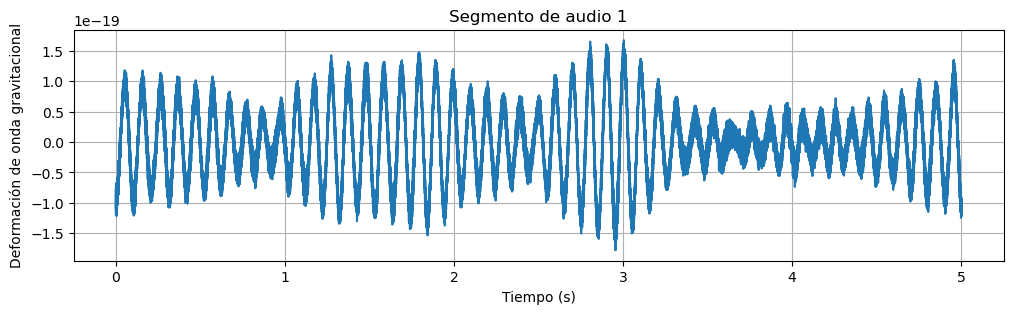

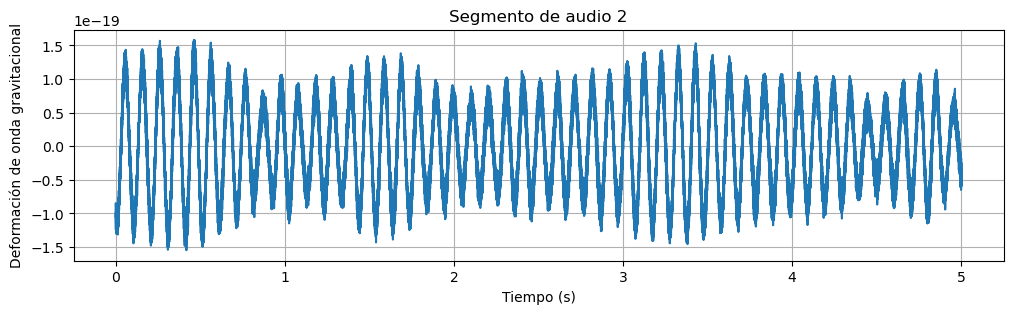

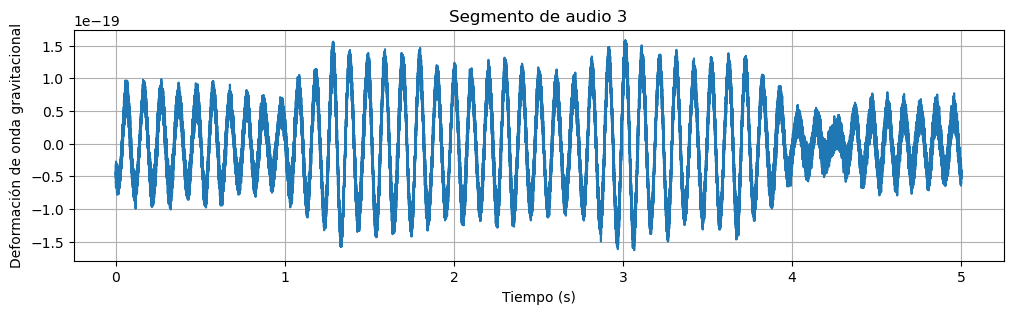

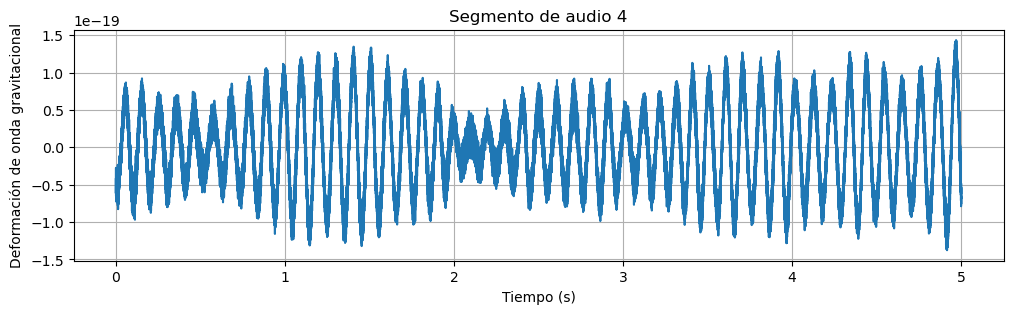

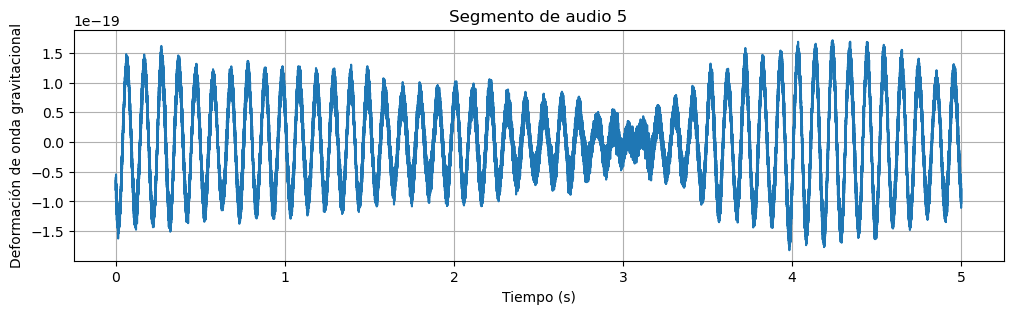

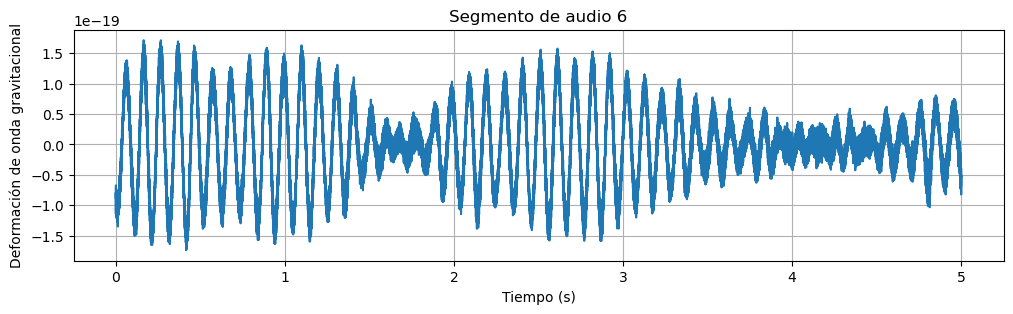

In [6]:
def plot_audio_segment(segment_data, segment_index, sample_rate):
    time = np.arange(len(segment_data)) / sample_rate
    plt.figure(figsize=(12, 3))
    plt.plot(time, segment_data)
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Deformación de onda gravitacional')
    plt.title(f'Segmento de audio {segment_index}')
    plt.grid(True)
    plt.show()


# Graficar cada segmento
for i, segment_data in enumerate(segments):
    plot_audio_segment(segment_data, i+1, sample_rate)

## 3. Análisis de Fourier
Al realizar la conversión, queremos ver cuales son las componentes de ruido que más afectan al instrumento y debemos ignorar en el análisis. Eso se ve como "pico" o la apariencia de "peine".
Se debe presenta la densidad espectral de potencia antes y después de la función de Windowing.


## 3. Grafico y generacion de PSD(Power Spectral Density)

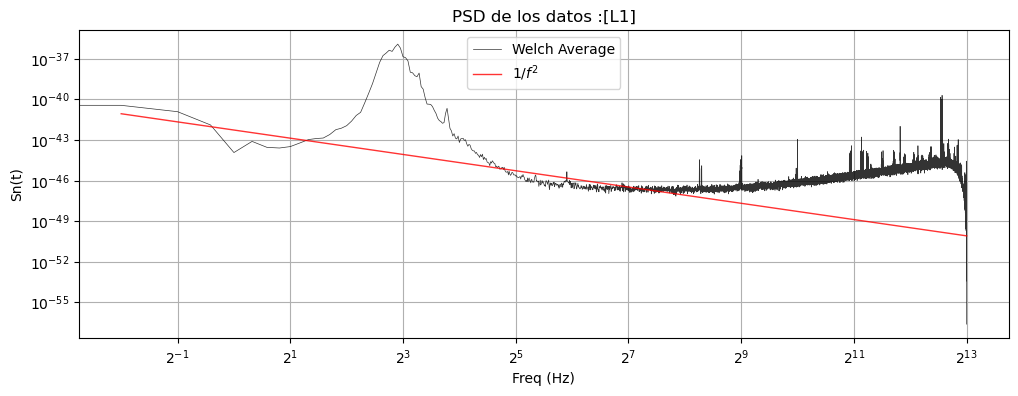

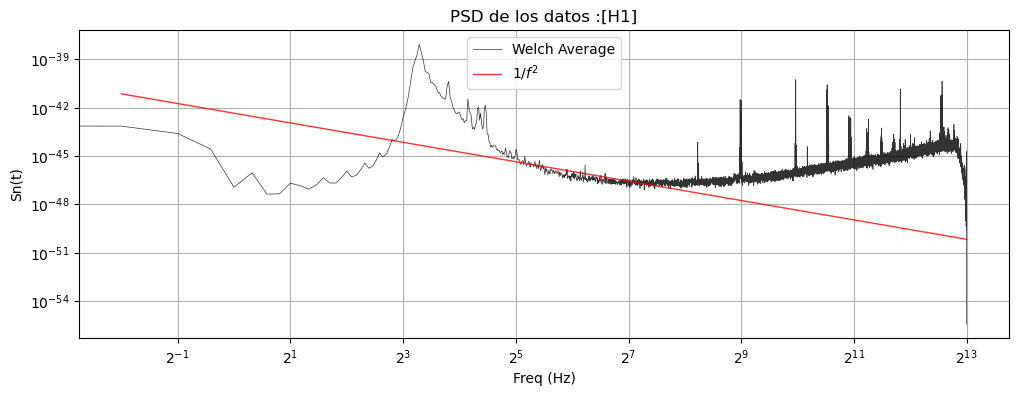

In [7]:
from scipy import signal
def get_psd(data, fs, NFFT,var, make_plot=False):

    # Calcular PSD usando la técnica de Welch
    f, Pxx = signal.welch(data, fs=fs, nperseg=NFFT, window='tukey')
    if make_plot:
        plt.figure(figsize=(12, 4))
        # Escala logarítmica en ambos ejes
        plt.xscale('log', base=2)
        plt.yscale('log', base=10)
        # Trama PSD
        plt.plot(f, Pxx, 'black', label='Welch Average', alpha=0.8, linewidth=0.5)

        # Plot 1/f^2
        # Calcula 1/f^2 y escalalo para que se ajuste a la trama PSD
        inverse_square = np.array([1 / (freq**2) for freq in f[1:]])
        scale_index = 500  # Elegido visualmente para ajustar la trama
        scale = Pxx[scale_index] / inverse_square[scale_index]
        
        plt.plot(f[1:], inverse_square * scale, 'red', label=r'$1 / f^2$', alpha=0.8, linewidth=1)
        plt.xlabel('Freq (Hz)')
        plt.ylabel('Sn(t)')
        plt.legend(loc='upper center')
        plt.title('PSD de los datos :'+var)
        plt.grid(True)
        plt.show()
    return Pxx, f

fs = 16384
NFFT = 4 * fs ##Longitud del segmento para calcular PSD
## Calcular PSD para L1
Pxx_L1, freqs_L1 = get_psd(data_L1, fs, NFFT,"[L1]",make_plot=True)
## Calcular PSD para H1
Pxx_H1, freqs_H1 = get_psd(data_H1, fs, NFFT,"[H1]",make_plot=True)


### 3. Operación realizada de Tukey Windowed a la señal

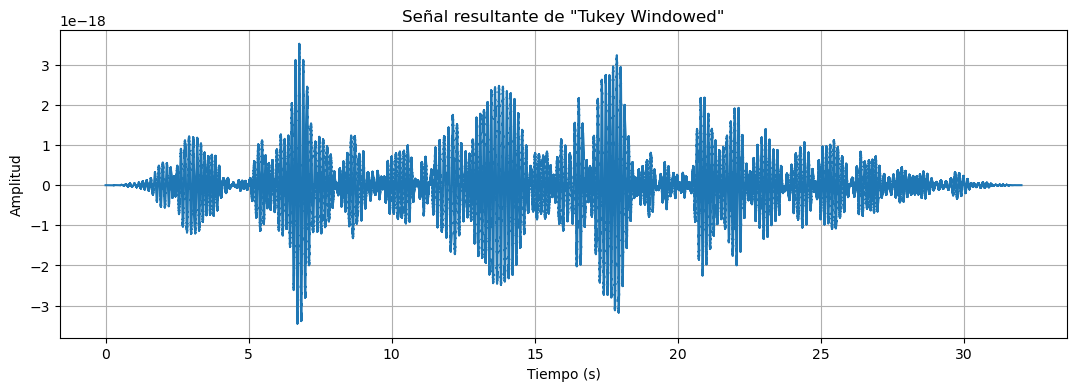

In [8]:
from scipy import signal
windowed_data_L1 = signal.windows.tukey(len(data_L1)) * data_L1
plt.figure(figsize=(13, 4))
plt.plot(time,windowed_data_L1)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Señal resultante de "Tukey Windowed"')
plt.grid(True)
plt.grid(True)
plt.show()

### 3. Filtrado por Whitening y posterior grafico

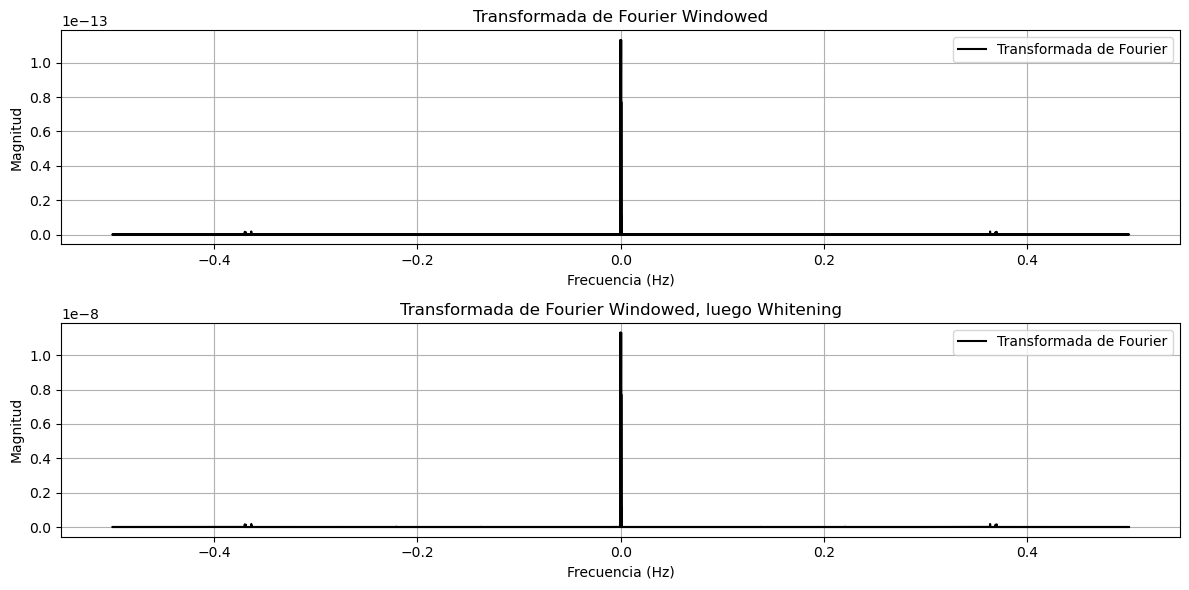

In [9]:
import numpy as np
fft_windowed_data_L1 = np.fft.fft(windowed_data_L1)
freqs = np.fft.fftfreq(len(data_L1))

# Calcula el promedio de los coeficientes de Fourier
mean_fft = np.mean(np.abs(fft_windowed_data_L1))
epsilon=1e-10
# Aplica el blanqueamiento
whitened_fft_data_L1 = fft_windowed_data_L1 / (np.sqrt(np.abs(freqs) * mean_fft+epsilon))

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)  
plt.plot(freqs, np.abs(fft_windowed_data_L1),color='black', label='Transformada de Fourier')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud')
plt.title('Transformada de Fourier Windowed')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)  
plt.plot(freqs, np.abs(whitened_fft_data_L1), color='black', label='Transformada de Fourier')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud')
plt.title('Transformada de Fourier Windowed, luego Whitening')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### 3. Aplicación de filtro pasa banda

In [10]:
def band_pass_filter(data, freqs, low_freq, high_freq):
    """
    Aplica un filtro pasa banda a los datos en el dominio de Fourier.

    Args:
        data (array): Los coeficientes de Fourier de los datos.
        freqs (array): Las frecuencias correspondientes.
        low_freq (float): Frecuencia mínima para pasar el filtro.
        high_freq (float): Frecuencia máxima para pasar el filtro.

    Returns:
        array: Los coeficientes de Fourier filtrados.
    """
    filtered_data = np.zeros_like(data)
    filtered_data[(freqs >= low_freq) & (freqs <= high_freq)] = data[(freqs >= low_freq) & (freqs <= high_freq)]
    filtered_data[(freqs <= -low_freq) & (freqs >= -high_freq)] = data[(freqs <= -low_freq) & (freqs >= -high_freq)]
    return filtered_data


# Definir las frecuencias de corte para el filtro pasa banda
low_freq = -0.4  # Frecuencia mínima en Hz
high_freq = 0.4 # Frecuencia máxima en Hz

# Aplicar el filtro pasa banda
filtered_fft_data_L1 = band_pass_filter(whitened_fft_data_L1, freqs, low_freq, high_freq)

##filtered_fft_data_L1[(freqs >= 0) & (freqs <= 0.1)] = 0
##filtered_fft_data_L1[(freqs <= -0) & (freqs >= -0.1)] = 0



### 3. Aplicación de un segundo filtrado en el dominio de la frecuencia

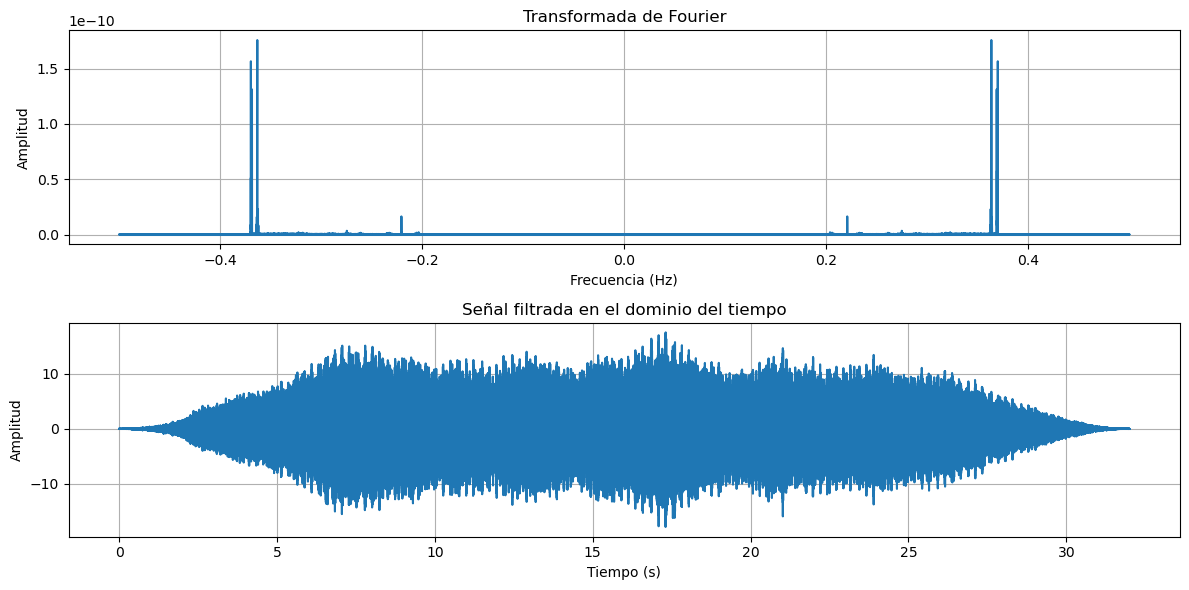

In [11]:
filtered_fft_data_L2=filtered_fft_data_L1
filtered_fft_data_L1 = band_pass_filter(filtered_fft_data_L1, freqs, 0.2,0.37)
filtered_data_L1 = np.fft.ifft(filtered_fft_data_L1).real

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(freqs, np.abs(filtered_fft_data_L1))
plt.xlabel('Frecuencia (Hz)')

plt.ylabel('Amplitud')
plt.grid(True)
plt.title('Transformada de Fourier')
filtered_data_L1 = filtered_data_L1*(2*1000000000000)
filtered_data_L1 = filtered_data_L1*10
filtered_data_L1=filtered_data_L1*170
# Grafica la señal resultante en el dominio del tiempo
plt.subplot(2, 1, 2)
plt.plot(time, filtered_data_L1)

plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Señal filtrada en el dominio del tiempo')
plt.grid(True)
plt.tight_layout()
plt.show()

### 3. Reproducción del segmento de audio filtrado

In [12]:
from scipy.io.wavfile import write
from IPython.display import Audio
filtered_data_L1=filtered_data_L1*200
write('filtered_audio.wav', sample_rate, filtered_data_L1.astype(np.int16))

# Reproducir el archivo de audio
audio_display = Audio('filtered_audio.wav')
audio_display

## 4. Procesamiento 
Debes inferir de tu estudio, cual es el proceso que aplican a la señal y reproducirlo. Es posible que cada estudiante llegue a una solución más o menos diferente, pues no hay un código abierto donde esté el procedimiento completo.


### 4. En general los pasos a seguir para trabajar este tipo de ondas gravitacionales son:

* Filtrado de Windowed tipo Tukey: Consiste en suavizar las discontinuidades en el tiempo mediante la ventana Tukey, ayuda a minimizar el efecto por la truncación de la señal en el dominio de la frecuencia.

* Filtrado mediante Whitening(Dom. Fourier): Este metodo consiste en normalizar lo coeficientes de fourier para igualar la distribucion de energia en todo ell espectro de la frecuencia, lo que atenua las frecuencias mas altas.

* Filtrado mediante filtro pasa banda: Consiste en que


# Resampling
Para lograr una mejor definición de la señal, se debe hacer un resampleo. Esto tienen consecuencias por eso debe elegirse bien la frecuencia de tal forma que no se introduzca ruido.